In [1]:
import tensorflow as tf
from tensorflow import keras
from loguru import logger
from tensorflow.keras.models import Model
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
# gpus = tf.config.list_logical_devices('GPU')
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=gpus,cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [3]:

training_dir = "autoencoder/pics/denver1"
training_dir_uch = "autoencoder/pics/uchtdorf1"
image_size = (256, 256)


train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
        # preprocessing_function=add_noise
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
        # preprocessing_function=add_noise
        )

In [4]:
train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=128,
        class_mode='input',
        color_mode="grayscale",
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=128,
        class_mode='input',
        color_mode="grayscale",
        subset="validation",
        seed=42)



train_generator_uch = train_datagen.flow_from_directory(
        training_dir_uch,
        target_size = image_size,
        subset="training",
        batch_size=128,
        class_mode='input',
        color_mode="grayscale",
        seed=42,shuffle=True)
validation_generator_uch = validation_datagen.flow_from_directory(
        training_dir_uch,
        target_size=image_size,
        batch_size=128,
        class_mode='input',
        color_mode="grayscale",
        subset="validation",
        seed=42)

Found 726 images belonging to 1 classes.
Found 181 images belonging to 1 classes.
Found 1463 images belonging to 1 classes.
Found 365 images belonging to 1 classes.


In [5]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         classes=['test'],
#         target_size=image_size,
#         class_mode='sparse',
#         shuffle=False)

In [6]:

# ourdata=tf.keras.preprocessing.image_dataset_from_directory(train,shuffle=True,
#                                                      batch_size=64,image_size=(256, 256),seed=123)
# uch=tf.keras.preprocessing.image_dataset_from_directory(train_uch,shuffle=True,
#                                                      batch_size=64,image_size=(256, 256),seed=123)
# def normalizer(generator):
#   normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#   def change_inputs(images, labels):
#     x = tf.image.resize(normalization_layer(images),[256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     return x, x

#   return generator.map(change_inputs)
# normalized = normalizer(ourdata)
# normalized_uchtdorf = normalizer(uch)

In [7]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 256*256
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

class Sampling(tf.keras.layers.Layer):
    """Uses (encoder_mu, encoder_log_variance) to sample encoder, the vector encoding a digit."""

    def call(self, inputs):
        encoder_mu, encoder_log_variance = inputs
        batch = tf.shape(encoder_mu)[0]
        dim = tf.shape(encoder_mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return encoder_mu + tf.exp(0.5 * encoder_log_variance) * epsilon



latent_space_dim=128
input_shape=(256,256,1)

'''encoder'''
encoder_input = tf.keras.layers.Input(shape=input_shape)
net = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1)(encoder_input)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2)(net)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", strides=4)(net)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1)(net)
net = tf.keras.layers.LeakyReLU()(net)
shape_before_flatten = K.int_shape(net)[1:]
net = tf.keras.layers.Flatten()(net)
encoder_mu = tf.keras.layers.Dense(units=latent_space_dim)(net)
encoder_log_variance = tf.keras.layers.Dense(units=latent_space_dim)(net)

# custom layer - will not run on DPU
encoder_z = Sampling()([encoder_mu, encoder_log_variance])

# encoder_mu,encoder_log_variance outputs go to loss function
# encoder_z is encoded latent space
encoder=Model(inputs=encoder_input, outputs=[encoder_mu,encoder_log_variance,encoder_z])


''' decoder '''
decoder_input = tf.keras.layers.Input(shape=latent_space_dim)
net = tf.keras.layers.Dense(units=np.prod(shape_before_flatten))(decoder_input)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Reshape(target_shape=shape_before_flatten)(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=1)(net)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=4)(net)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=2)(net)
net = tf.keras.layers.LeakyReLU()(net)
decoder_output = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", activation="sigmoid",strides=1)(net)


# standard sigmoid
#decoder_output = Activation('sigmoid')(net)

decoder = Model(inputs=decoder_input, outputs=decoder_output)

In [8]:

image_dim = 256
image_chan = 1
input_layer = tf.keras.layers.Input(shape=(image_dim,image_dim,image_chan))
encoder_mu, encoder_log_variance, encoder_z = encoder.call(input_layer)

dec_out = decoder.call(encoder_z)
model = Model(inputs=input_layer, outputs=dec_out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 32  0           ['conv2d[1][0]']                 
                                )                                                           

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_func(encoder_mu,encoder_log_variance),
              metrics=['mse'])

In [10]:
face = cv2.imread("autoencoder/pics/denver1/denver/denver_face1748.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
# plt.imshow(face)
# plt.show()
face = cv2.resize(face,(256,256))
face = np.reshape(face, (1,256,256,1))
face = face/255

In [11]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        uch_pred = encoder.predict(face)
        output = decoder.predict(uch_pred)
        output = np.reshape(output,(256,256))
        output = output*255
        plt.imshow(output)
        plt.savefig(f'created_img/img{epoch}.png',bbox_inches='tight',transparent=True, pad_inches=0)
        if epoch % 8 == 0:
            plt.imshow(output)
            plt.show()

2022-12-01 18:24:59.099191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 18:25:12.970648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38236 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2022-12-01 18:25:13.026696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38236 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-12-01 18:25:13.028582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

Epoch 1/300


2022-12-01 18:25:16.533492: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-12-01 18:25:18.088595: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-01 18:25:19.122510: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


6/6 [==============================] - ETA: 0s - batch: 2.5000 - size: 121.0000 - loss: 3409.6971 - mse: 0.0516 

/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


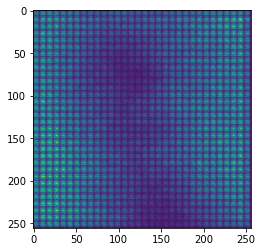

6/6 [==============================] - 16s 2s/step - batch: 2.5000 - size: 121.0000 - loss: 3419.2013 - mse: 0.0516 - val_loss: 2402.9135 - val_mse: 0.0351
Epoch 2/300
6/6 [==============================] - 3s 626ms/step - batch: 2.5000 - size: 121.0000 - loss: 2011.0315 - mse: 0.0292 - val_loss: 1581.4646 - val_mse: 0.0231
Epoch 3/300
6/6 [==============================] - 5s 984ms/step - batch: 2.5000 - size: 121.0000 - loss: 1591.6825 - mse: 0.0229 - val_loss: 1640.8688 - val_mse: 0.0236
Epoch 4/300
6/6 [==============================] - 5s 997ms/step - batch: 2.5000 - size: 121.0000 - loss: 1538.9292 - mse: 0.0221 - val_loss: 1524.8826 - val_mse: 0.0218
Epoch 5/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1528.0342 - mse: 0.0219 - val_loss: 1468.6832 - val_mse: 0.0211
Epoch 6/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1489.7056 - mse: 0.0213 - val_loss: 1520.5268 - val_mse: 0.0219


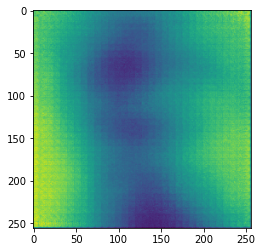

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1472.4961 - mse: 0.0211 - val_loss: 1449.6356 - val_mse: 0.0207
Epoch 10/300
6/6 [==============================] - 5s 928ms/step - batch: 2.5000 - size: 121.0000 - loss: 1447.5312 - mse: 0.0207 - val_loss: 1441.1265 - val_mse: 0.0208
Epoch 11/300
6/6 [==============================] - 5s 981ms/step - batch: 2.5000 - size: 121.0000 - loss: 1460.3428 - mse: 0.0209 - val_loss: 1469.3188 - val_mse: 0.0211
Epoch 12/300
6/6 [==============================] - 5s 984ms/step - batch: 2.5000 - size: 121.0000 - loss: 1499.6065 - mse: 0.0214 - val_loss: 1448.6544 - val_mse: 0.0208
Epoch 13/300
6/6 [==============================] - 5s 986ms/step - batch: 2.5000 - size: 121.0000 - loss: 1444.6214 - mse: 0.0206 - val_loss: 1452.9386 - val_mse: 0.0206
Epoch 14/300
6/6 [==============================] - 5s 991ms/step - batch: 2.5000 - size: 121.0000 - loss: 1431.8812 - mse: 0.0205 - val_loss: 1442.0939 - val_ms

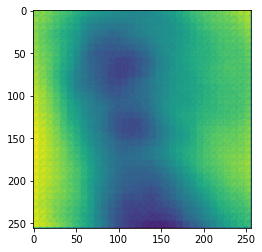

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1426.0992 - mse: 0.0204 - val_loss: 1423.1796 - val_mse: 0.0204
Epoch 18/300
6/6 [==============================] - 5s 931ms/step - batch: 2.5000 - size: 121.0000 - loss: 1418.0579 - mse: 0.0202 - val_loss: 1336.2935 - val_mse: 0.0191
Epoch 19/300
6/6 [==============================] - 5s 987ms/step - batch: 2.5000 - size: 121.0000 - loss: 1362.0069 - mse: 0.0194 - val_loss: 1293.8542 - val_mse: 0.0183
Epoch 20/300
6/6 [==============================] - 5s 962ms/step - batch: 2.5000 - size: 121.0000 - loss: 1274.4464 - mse: 0.0181 - val_loss: 1338.1858 - val_mse: 0.0189
Epoch 21/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1259.3241 - mse: 0.0178 - val_loss: 1233.8849 - val_mse: 0.0175
Epoch 22/300
6/6 [==============================] - 5s 961ms/step - batch: 2.5000 - size: 121.0000 - loss: 1201.0786 - mse: 0.0169 - val_loss: 1189.3715 - val_mse: 

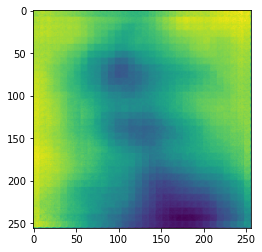

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1112.7093 - mse: 0.0156 - val_loss: 1062.1183 - val_mse: 0.0149
Epoch 26/300
6/6 [==============================] - 5s 948ms/step - batch: 2.5000 - size: 121.0000 - loss: 1078.7715 - mse: 0.0150 - val_loss: 1041.6241 - val_mse: 0.0146
Epoch 27/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 1033.5965 - mse: 0.0144 - val_loss: 1015.0733 - val_mse: 0.0139
Epoch 28/300
6/6 [==============================] - 5s 986ms/step - batch: 2.5000 - size: 121.0000 - loss: 1003.7521 - mse: 0.0139 - val_loss: 1048.9402 - val_mse: 0.0145
Epoch 29/300
6/6 [==============================] - 5s 987ms/step - batch: 2.5000 - size: 121.0000 - loss: 1031.3156 - mse: 0.0144 - val_loss: 1001.4561 - val_mse: 0.0140
Epoch 30/300
6/6 [==============================] - 5s 978ms/step - batch: 2.5000 - size: 121.0000 - loss: 1002.9830 - mse: 0.0139 - val_loss: 965.7870 - val_mse: 0

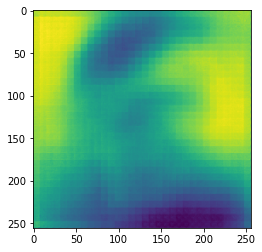

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 925.8419 - mse: 0.0127 - val_loss: 905.9605 - val_mse: 0.0124
Epoch 34/300
6/6 [==============================] - 5s 982ms/step - batch: 2.5000 - size: 121.0000 - loss: 893.1824 - mse: 0.0122 - val_loss: 866.9674 - val_mse: 0.0120
Epoch 35/300
6/6 [==============================] - 5s 975ms/step - batch: 2.5000 - size: 121.0000 - loss: 863.4424 - mse: 0.0118 - val_loss: 867.9671 - val_mse: 0.0118
Epoch 36/300
6/6 [==============================] - 5s 948ms/step - batch: 2.5000 - size: 121.0000 - loss: 845.0577 - mse: 0.0115 - val_loss: 830.1387 - val_mse: 0.0113
Epoch 37/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 836.6431 - mse: 0.0114 - val_loss: 855.0962 - val_mse: 0.0117
Epoch 38/300
6/6 [==============================] - 5s 980ms/step - batch: 2.5000 - size: 121.0000 - loss: 844.4224 - mse: 0.0115 - val_loss: 813.3524 - val_mse: 0.0110
Epoch

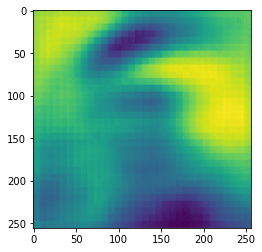

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 790.1564 - mse: 0.0106 - val_loss: 776.8756 - val_mse: 0.0105
Epoch 42/300
6/6 [==============================] - 5s 928ms/step - batch: 2.5000 - size: 121.0000 - loss: 774.1582 - mse: 0.0104 - val_loss: 777.1946 - val_mse: 0.0104
Epoch 43/300
6/6 [==============================] - 5s 937ms/step - batch: 2.5000 - size: 121.0000 - loss: 765.8999 - mse: 0.0102 - val_loss: 725.6734 - val_mse: 0.0098
Epoch 44/300
6/6 [==============================] - 5s 990ms/step - batch: 2.5000 - size: 121.0000 - loss: 754.5902 - mse: 0.0101 - val_loss: 732.6814 - val_mse: 0.0099
Epoch 45/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 736.8975 - mse: 0.0098 - val_loss: 726.8324 - val_mse: 0.0097
Epoch 46/300
6/6 [==============================] - 5s 975ms/step - batch: 2.5000 - size: 121.0000 - loss: 720.5383 - mse: 0.0096 - val_loss: 702.9237 - val_mse: 0.0094
Epoch

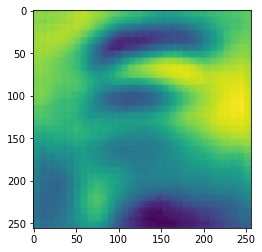

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 695.0871 - mse: 0.0092 - val_loss: 697.0294 - val_mse: 0.0093
Epoch 50/300
6/6 [==============================] - 5s 926ms/step - batch: 2.5000 - size: 121.0000 - loss: 684.6171 - mse: 0.0090 - val_loss: 682.6235 - val_mse: 0.0089
Epoch 51/300
6/6 [==============================] - 5s 947ms/step - batch: 2.5000 - size: 121.0000 - loss: 686.1794 - mse: 0.0090 - val_loss: 663.2240 - val_mse: 0.0087
Epoch 52/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 666.1173 - mse: 0.0087 - val_loss: 648.4711 - val_mse: 0.0085
Epoch 53/300
6/6 [==============================] - 5s 968ms/step - batch: 2.5000 - size: 121.0000 - loss: 662.9376 - mse: 0.0087 - val_loss: 660.0135 - val_mse: 0.0087
Epoch 54/300
6/6 [==============================] - 5s 984ms/step - batch: 2.5000 - size: 121.0000 - loss: 649.3855 - mse: 0.0085 - val_loss: 653.3909 - val_mse: 0.0084
Epoch

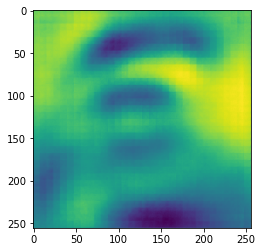

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 626.9311 - mse: 0.0082 - val_loss: 621.7997 - val_mse: 0.0081
Epoch 58/300
6/6 [==============================] - 5s 943ms/step - batch: 2.5000 - size: 121.0000 - loss: 620.7712 - mse: 0.0080 - val_loss: 607.8243 - val_mse: 0.0080
Epoch 59/300
6/6 [==============================] - 5s 978ms/step - batch: 2.5000 - size: 121.0000 - loss: 612.8791 - mse: 0.0080 - val_loss: 628.6078 - val_mse: 0.0082
Epoch 60/300
6/6 [==============================] - 5s 946ms/step - batch: 2.5000 - size: 121.0000 - loss: 623.9261 - mse: 0.0081 - val_loss: 606.6862 - val_mse: 0.0079
Epoch 61/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 611.4537 - mse: 0.0079 - val_loss: 596.3816 - val_mse: 0.0076
Epoch 62/300
6/6 [==============================] - 5s 971ms/step - batch: 2.5000 - size: 121.0000 - loss: 598.7951 - mse: 0.0077 - val_loss: 593.8922 - val_mse: 0.0076
Epoch

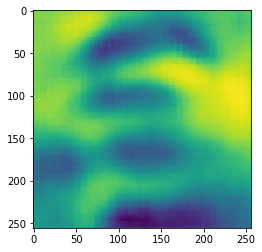

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 576.2225 - mse: 0.0074 - val_loss: 564.8918 - val_mse: 0.0073
Epoch 66/300
6/6 [==============================] - 5s 970ms/step - batch: 2.5000 - size: 121.0000 - loss: 570.0471 - mse: 0.0073 - val_loss: 583.8183 - val_mse: 0.0076
Epoch 67/300
6/6 [==============================] - 5s 989ms/step - batch: 2.5000 - size: 121.0000 - loss: 576.3929 - mse: 0.0074 - val_loss: 558.3647 - val_mse: 0.0071
Epoch 68/300
6/6 [==============================] - 5s 973ms/step - batch: 2.5000 - size: 121.0000 - loss: 563.1435 - mse: 0.0072 - val_loss: 572.0495 - val_mse: 0.0072
Epoch 69/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 554.2747 - mse: 0.0070 - val_loss: 529.1169 - val_mse: 0.0068
Epoch 70/300
6/6 [==============================] - 5s 964ms/step - batch: 2.5000 - size: 121.0000 - loss: 546.8357 - mse: 0.0069 - val_loss: 522.4729 - val_mse: 0.0067
Epoch

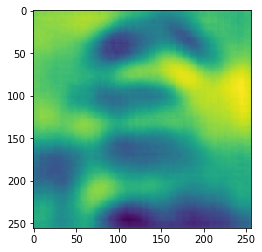

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 535.4613 - mse: 0.0067 - val_loss: 523.3293 - val_mse: 0.0066
Epoch 74/300
6/6 [==============================] - 5s 950ms/step - batch: 2.5000 - size: 121.0000 - loss: 529.4826 - mse: 0.0067 - val_loss: 529.9193 - val_mse: 0.0067
Epoch 75/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 525.2463 - mse: 0.0066 - val_loss: 516.4165 - val_mse: 0.0063
Epoch 76/300
6/6 [==============================] - 5s 983ms/step - batch: 2.5000 - size: 121.0000 - loss: 520.8806 - mse: 0.0065 - val_loss: 510.5298 - val_mse: 0.0064
Epoch 77/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 522.5644 - mse: 0.0065 - val_loss: 539.0568 - val_mse: 0.0068
Epoch 78/300
6/6 [==============================] - 5s 954ms/step - batch: 2.5000 - size: 121.0000 - loss: 537.5359 - mse: 0.0068 - val_loss: 522.4382 - val_mse: 0.0065
Epoch 79

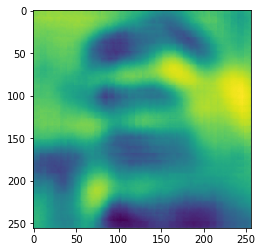

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 503.8202 - mse: 0.0063 - val_loss: 504.2704 - val_mse: 0.0063
Epoch 82/300
6/6 [==============================] - 5s 943ms/step - batch: 2.5000 - size: 121.0000 - loss: 501.4159 - mse: 0.0062 - val_loss: 498.1318 - val_mse: 0.0061
Epoch 83/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 499.3246 - mse: 0.0062 - val_loss: 484.8941 - val_mse: 0.0060
Epoch 84/300
6/6 [==============================] - 5s 979ms/step - batch: 2.5000 - size: 121.0000 - loss: 493.1028 - mse: 0.0061 - val_loss: 481.7700 - val_mse: 0.0060
Epoch 85/300
6/6 [==============================] - 5s 999ms/step - batch: 2.5000 - size: 121.0000 - loss: 490.2356 - mse: 0.0061 - val_loss: 483.8298 - val_mse: 0.0059
Epoch 86/300
6/6 [==============================] - 5s 970ms/step - batch: 2.5000 - size: 121.0000 - loss: 497.9883 - mse: 0.0062 - val_loss: 489.7936 - val_mse: 0.0061
Epoch

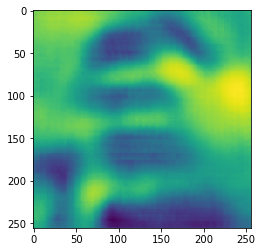

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 479.1808 - mse: 0.0059 - val_loss: 470.9443 - val_mse: 0.0058
Epoch 90/300
6/6 [==============================] - 5s 950ms/step - batch: 2.5000 - size: 121.0000 - loss: 475.1825 - mse: 0.0058 - val_loss: 479.6154 - val_mse: 0.0057
Epoch 91/300
6/6 [==============================] - 5s 940ms/step - batch: 2.5000 - size: 121.0000 - loss: 468.0452 - mse: 0.0057 - val_loss: 472.8322 - val_mse: 0.0057
Epoch 92/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 470.3792 - mse: 0.0057 - val_loss: 464.4270 - val_mse: 0.0056
Epoch 93/300
6/6 [==============================] - 5s 978ms/step - batch: 2.5000 - size: 121.0000 - loss: 464.5315 - mse: 0.0057 - val_loss: 473.4105 - val_mse: 0.0057
Epoch 94/300
6/6 [==============================] - 5s 946ms/step - batch: 2.5000 - size: 121.0000 - loss: 468.2686 - mse: 0.0057 - val_loss: 461.7905 - val_mse: 0.0055
Epoch

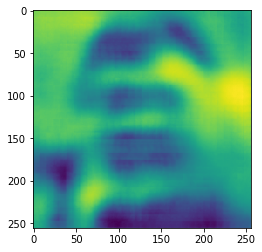

6/6 [==============================] - 5s 979ms/step - batch: 2.5000 - size: 121.0000 - loss: 472.8787 - mse: 0.0058 - val_loss: 444.7965 - val_mse: 0.0054
Epoch 98/300
6/6 [==============================] - 5s 974ms/step - batch: 2.5000 - size: 121.0000 - loss: 456.8686 - mse: 0.0055 - val_loss: 440.8624 - val_mse: 0.0054
Epoch 99/300
6/6 [==============================] - 5s 974ms/step - batch: 2.5000 - size: 121.0000 - loss: 453.0702 - mse: 0.0055 - val_loss: 438.7830 - val_mse: 0.0053
Epoch 100/300
6/6 [==============================] - 5s 960ms/step - batch: 2.5000 - size: 121.0000 - loss: 447.3800 - mse: 0.0054 - val_loss: 437.1987 - val_mse: 0.0052
Epoch 101/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 447.2221 - mse: 0.0054 - val_loss: 454.7371 - val_mse: 0.0053
Epoch 102/300
6/6 [==============================] - 5s 986ms/step - batch: 2.5000 - size: 121.0000 - loss: 447.2404 - mse: 0.0054 - val_loss: 469.3020 - val_mse: 0.0057

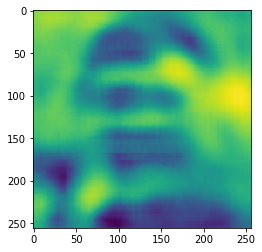

6/6 [==============================] - 5s 990ms/step - batch: 2.5000 - size: 121.0000 - loss: 442.8436 - mse: 0.0053 - val_loss: 438.5441 - val_mse: 0.0053
Epoch 106/300
6/6 [==============================] - 5s 961ms/step - batch: 2.5000 - size: 121.0000 - loss: 447.3116 - mse: 0.0054 - val_loss: 446.3932 - val_mse: 0.0054
Epoch 107/300
6/6 [==============================] - 5s 974ms/step - batch: 2.5000 - size: 121.0000 - loss: 440.1677 - mse: 0.0053 - val_loss: 440.7458 - val_mse: 0.0054
Epoch 108/300
6/6 [==============================] - 5s 981ms/step - batch: 2.5000 - size: 121.0000 - loss: 441.5552 - mse: 0.0053 - val_loss: 429.3330 - val_mse: 0.0051
Epoch 109/300
6/6 [==============================] - 5s 996ms/step - batch: 2.5000 - size: 121.0000 - loss: 439.6563 - mse: 0.0053 - val_loss: 438.7971 - val_mse: 0.0051
Epoch 110/300
6/6 [==============================] - 5s 969ms/step - batch: 2.5000 - size: 121.0000 - loss: 435.0022 - mse: 0.0052 - val_loss: 434.8735 - val_mse: 0

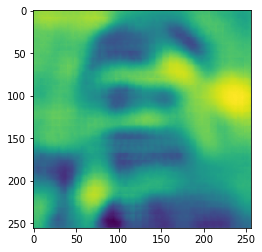

6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 429.7585 - mse: 0.0051 - val_loss: 419.5415 - val_mse: 0.0049
Epoch 114/300
6/6 [==============================] - 5s 962ms/step - batch: 2.5000 - size: 121.0000 - loss: 423.4705 - mse: 0.0050 - val_loss: 413.4283 - val_mse: 0.0050
Epoch 115/300
6/6 [==============================] - 5s 979ms/step - batch: 2.5000 - size: 121.0000 - loss: 421.4817 - mse: 0.0050 - val_loss: 425.3019 - val_mse: 0.0050
Epoch 116/300
6/6 [==============================] - 5s 986ms/step - batch: 2.5000 - size: 121.0000 - loss: 416.6167 - mse: 0.0049 - val_loss: 414.6926 - val_mse: 0.0049
Epoch 117/300
6/6 [==============================] - 5s 988ms/step - batch: 2.5000 - size: 121.0000 - loss: 419.7582 - mse: 0.0050 - val_loss: 423.9090 - val_mse: 0.0052
Epoch 118/300
6/6 [==============================] - 5s 1s/step - batch: 2.5000 - size: 121.0000 - loss: 424.5824 - mse: 0.0051 - val_loss: 409.5432 - val_mse: 0.0048


In [ ]:

model.fit(
    x=train_generator,
    epochs=300,
    shuffle=True,
    validation_data = validation_generator,
    callbacks=[CustomCallback()]
)
model.save("bryan_ae.h5")

In [19]:
import cv2
import glob
import re
import os
img_array = []

for filename in sorted(glob.glob('created_img/*.png'),key=lambda x: int(re.findall("[0-9]+", x)[0])):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


In [39]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 256*256
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

class Sampling(tf.keras.layers.Layer):
    """Uses (encoder_mu, encoder_log_variance) to sample encoder, the vector encoding a digit."""

    def call(self, inputs):
        encoder_mu, encoder_log_variance = inputs
        batch = tf.shape(encoder_mu)[0]
        dim = tf.shape(encoder_mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return encoder_mu + tf.exp(0.5 * encoder_log_variance) * epsilon



latent_space_dim=128
input_shape2=(256,256,1)

'''encoder'''
encoder_input2 = tf.keras.layers.Input(shape=input_shape2)
net = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1)(encoder_input2)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2)(net)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", strides=4)(net)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", strides=1)(net)

net = tf.keras.layers.LeakyReLU()(net)
shape_before_flatten2 = K.int_shape(net)[1:]
net = tf.keras.layers.Flatten()(net)
encoder_mu2 = tf.keras.layers.Dense(units=latent_space_dim)(net)
encoder_log_variance2 = tf.keras.layers.Dense(units=latent_space_dim)(net)

# custom layer - will not run on DPU
encoder_z2 = Sampling()([encoder_mu2, encoder_log_variance2])

# encoder_mu,encoder_log_variance outputs go to loss function
# encoder_z is encoded latent space
encoder_uch=Model(inputs=encoder_input2, outputs=[encoder_mu2,encoder_log_variance2,encoder_z2])


''' decoder '''
decoder_input2 = tf.keras.layers.Input(shape=latent_space_dim)
net = tf.keras.layers.Dense(units=np.prod(shape_before_flatten2))(decoder_input2)
net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Reshape(target_shape=shape_before_flatten2)(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=1)(net)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=4)(net)

net = tf.keras.layers.LeakyReLU()(net)
net = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=2)(net)

net = tf.keras.layers.LeakyReLU()(net)
decoder_output2 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same",activation='sigmoid', strides=1)(net)

# standard sigmoid
#decoder_output = Activation('sigmoid')(net)

decoder_uch = Model(inputs=decoder_input2, outputs=decoder_output2)

In [40]:

image_dim = 256
image_chan = 1
input_layer = tf.keras.layers.Input(shape=(image_dim,image_dim,image_chan))
encoder_mu2, encoder_log_variance2, encoder_z2 = encoder_uch.call(input_layer)

dec_out = decoder_uch.call(encoder_z2)
model_uch = Model(inputs=input_layer, outputs=dec_out)
model_uch.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 32  320         ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_42 (LeakyReLU)     (None, 256, 256, 32  0           ['conv2d_28[1][0]']              
                                )                                                          

In [41]:
model_uch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_func(encoder_mu,encoder_log_variance),
              metrics=['mse'])

In [42]:
face = cv2.imread("autoencoder/pics/uchtdorf1/uchtdorf/uchtdorf_face1860.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
# plt.imshow(face)
# plt.show()
face = cv2.resize(face,(256,256))
face = np.reshape(face, (1,256,256,1))
face = face/255

In [43]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        uch_pred = encoder_uch.predict(face)
        output = decoder_uch.predict(uch_pred)
        output = np.reshape(output,(256,256))
        output = output*255
        plt.imshow(output)
        plt.savefig(f'created_img/img{epoch}.png',bbox_inches='tight',transparent=True, pad_inches=0)
        if epoch % 8 == 0:
            plt.imshow(output)
            plt.show()

Epoch 1/300
12/12 [==============================] - ETA: 0s - batch: 5.5000 - size: 121.9167 - loss: 3904.6757 - mse: 0.0602

/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


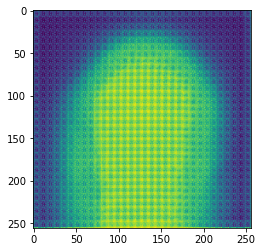

12/12 [==============================] - 13s 1s/step - batch: 5.5000 - size: 121.9167 - loss: 3909.2285 - mse: 0.0602 - val_loss: 2049.3088 - val_mse: 0.0310
Epoch 2/300
12/12 [==============================] - 10s 888ms/step - batch: 5.5000 - size: 121.9167 - loss: 1679.9939 - mse: 0.0253 - val_loss: 1377.6626 - val_mse: 0.0207
Epoch 3/300
12/12 [==============================] - 10s 884ms/step - batch: 5.5000 - size: 121.9167 - loss: 1265.7382 - mse: 0.0191 - val_loss: 1146.2621 - val_mse: 0.0172
Epoch 4/300
12/12 [==============================] - 11s 948ms/step - batch: 5.5000 - size: 121.9167 - loss: 1038.8915 - mse: 0.0156 - val_loss: 966.2074 - val_mse: 0.0145
Epoch 5/300
12/12 [==============================] - 10s 895ms/step - batch: 5.5000 - size: 121.9167 - loss: 906.1105 - mse: 0.0136 - val_loss: 877.0099 - val_mse: 0.0132
Epoch 6/300
12/12 [==============================] - 10s 922ms/step - batch: 5.5000 - size: 121.9167 - loss: 830.1656 - mse: 0.0124 - val_loss: 813.7717 

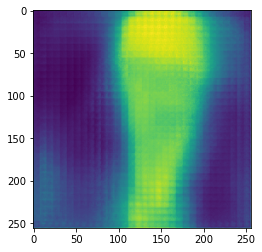

12/12 [==============================] - 10s 932ms/step - batch: 5.5000 - size: 121.9167 - loss: 613.7595 - mse: 0.0091 - val_loss: 609.6707 - val_mse: 0.0091
Epoch 10/300
12/12 [==============================] - 10s 909ms/step - batch: 5.5000 - size: 121.9167 - loss: 586.7953 - mse: 0.0087 - val_loss: 590.1396 - val_mse: 0.0087
Epoch 11/300
12/12 [==============================] - 10s 909ms/step - batch: 5.5000 - size: 121.9167 - loss: 562.2063 - mse: 0.0084 - val_loss: 525.9352 - val_mse: 0.0078
Epoch 12/300
12/12 [==============================] - 10s 926ms/step - batch: 5.5000 - size: 121.9167 - loss: 539.3183 - mse: 0.0080 - val_loss: 517.9410 - val_mse: 0.0077
Epoch 13/300
12/12 [==============================] - 10s 911ms/step - batch: 5.5000 - size: 121.9167 - loss: 516.2907 - mse: 0.0076 - val_loss: 499.8425 - val_mse: 0.0074
Epoch 14/300
12/12 [==============================] - 11s 931ms/step - batch: 5.5000 - size: 121.9167 - loss: 490.1256 - mse: 0.0072 - val_loss: 487.2252

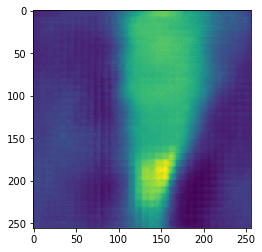

12/12 [==============================] - 11s 963ms/step - batch: 5.5000 - size: 121.9167 - loss: 458.7940 - mse: 0.0068 - val_loss: 437.6432 - val_mse: 0.0064
Epoch 18/300
12/12 [==============================] - 10s 920ms/step - batch: 5.5000 - size: 121.9167 - loss: 433.9989 - mse: 0.0064 - val_loss: 432.7672 - val_mse: 0.0064
Epoch 19/300
12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 422.6615 - mse: 0.0062 - val_loss: 416.9658 - val_mse: 0.0061
Epoch 20/300
12/12 [==============================] - 10s 914ms/step - batch: 5.5000 - size: 121.9167 - loss: 407.9262 - mse: 0.0060 - val_loss: 395.0801 - val_mse: 0.0058
Epoch 21/300
12/12 [==============================] - 11s 934ms/step - batch: 5.5000 - size: 121.9167 - loss: 404.1164 - mse: 0.0059 - val_loss: 393.1177 - val_mse: 0.0057
Epoch 22/300
12/12 [==============================] - 11s 930ms/step - batch: 5.5000 - size: 121.9167 - loss: 389.1745 - mse: 0.0057 - val_loss: 386.0895

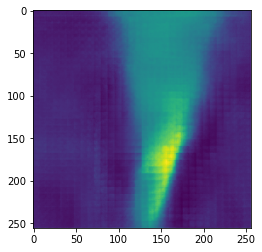

12/12 [==============================] - 11s 930ms/step - batch: 5.5000 - size: 121.9167 - loss: 359.8298 - mse: 0.0052 - val_loss: 360.3884 - val_mse: 0.0053
Epoch 26/300
12/12 [==============================] - 10s 901ms/step - batch: 5.5000 - size: 121.9167 - loss: 358.1895 - mse: 0.0052 - val_loss: 339.6836 - val_mse: 0.0049
Epoch 27/300
12/12 [==============================] - 10s 928ms/step - batch: 5.5000 - size: 121.9167 - loss: 348.9275 - mse: 0.0051 - val_loss: 344.4347 - val_mse: 0.0050
Epoch 28/300
12/12 [==============================] - 10s 922ms/step - batch: 5.5000 - size: 121.9167 - loss: 347.7564 - mse: 0.0051 - val_loss: 350.3535 - val_mse: 0.0051
Epoch 29/300
12/12 [==============================] - 10s 917ms/step - batch: 5.5000 - size: 121.9167 - loss: 345.4569 - mse: 0.0050 - val_loss: 342.4170 - val_mse: 0.0050
Epoch 30/300
12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 327.7814 - mse: 0.0048 - val_loss: 320.6636

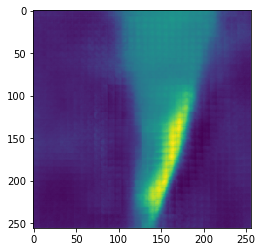

12/12 [==============================] - 11s 944ms/step - batch: 5.5000 - size: 121.9167 - loss: 311.9826 - mse: 0.0045 - val_loss: 312.4315 - val_mse: 0.0045
Epoch 34/300
12/12 [==============================] - 10s 891ms/step - batch: 5.5000 - size: 121.9167 - loss: 299.6808 - mse: 0.0043 - val_loss: 299.3684 - val_mse: 0.0043
Epoch 35/300
12/12 [==============================] - 10s 920ms/step - batch: 5.5000 - size: 121.9167 - loss: 301.4351 - mse: 0.0044 - val_loss: 296.1820 - val_mse: 0.0043
Epoch 36/300
12/12 [==============================] - 10s 925ms/step - batch: 5.5000 - size: 121.9167 - loss: 308.1659 - mse: 0.0045 - val_loss: 298.2416 - val_mse: 0.0043
Epoch 37/300
12/12 [==============================] - 10s 914ms/step - batch: 5.5000 - size: 121.9167 - loss: 294.1749 - mse: 0.0042 - val_loss: 281.9675 - val_mse: 0.0041
Epoch 38/300
12/12 [==============================] - 10s 925ms/step - batch: 5.5000 - size: 121.9167 - loss: 281.1632 - mse: 0.0040 - val_loss: 281.1713

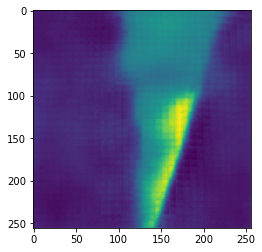

12/12 [==============================] - 11s 934ms/step - batch: 5.5000 - size: 121.9167 - loss: 271.5495 - mse: 0.0039 - val_loss: 266.3942 - val_mse: 0.0038
Epoch 42/300
12/12 [==============================] - 10s 897ms/step - batch: 5.5000 - size: 121.9167 - loss: 272.5930 - mse: 0.0039 - val_loss: 274.6191 - val_mse: 0.0040
Epoch 43/300
12/12 [==============================] - 10s 920ms/step - batch: 5.5000 - size: 121.9167 - loss: 267.6069 - mse: 0.0039 - val_loss: 275.5486 - val_mse: 0.0040
Epoch 44/300
12/12 [==============================] - 10s 897ms/step - batch: 5.5000 - size: 121.9167 - loss: 264.4315 - mse: 0.0038 - val_loss: 264.0287 - val_mse: 0.0038
Epoch 45/300
12/12 [==============================] - 11s 929ms/step - batch: 5.5000 - size: 121.9167 - loss: 256.7806 - mse: 0.0037 - val_loss: 257.3714 - val_mse: 0.0037
Epoch 46/300
12/12 [==============================] - 10s 929ms/step - batch: 5.5000 - size: 121.9167 - loss: 258.4170 - mse: 0.0037 - val_loss: 253.5722

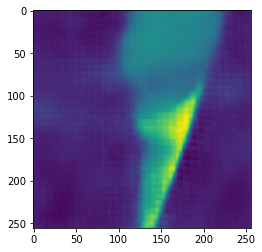

12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 252.9914 - mse: 0.0036 - val_loss: 255.1184 - val_mse: 0.0037
Epoch 50/300
12/12 [==============================] - 10s 912ms/step - batch: 5.5000 - size: 121.9167 - loss: 244.9382 - mse: 0.0035 - val_loss: 242.6295 - val_mse: 0.0034
Epoch 51/300
12/12 [==============================] - 10s 903ms/step - batch: 5.5000 - size: 121.9167 - loss: 241.3394 - mse: 0.0034 - val_loss: 238.9860 - val_mse: 0.0034
Epoch 52/300
12/12 [==============================] - 10s 916ms/step - batch: 5.5000 - size: 121.9167 - loss: 245.1147 - mse: 0.0035 - val_loss: 250.9873 - val_mse: 0.0036
Epoch 53/300
12/12 [==============================] - 10s 923ms/step - batch: 5.5000 - size: 121.9167 - loss: 246.6057 - mse: 0.0035 - val_loss: 250.3260 - val_mse: 0.0036
Epoch 54/300
12/12 [==============================] - 10s 912ms/step - batch: 5.5000 - size: 121.9167 - loss: 243.0627 - mse: 0.0035 - val_loss: 231.4851

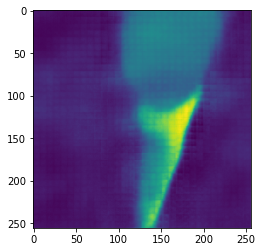

12/12 [==============================] - 11s 930ms/step - batch: 5.5000 - size: 121.9167 - loss: 234.1658 - mse: 0.0033 - val_loss: 231.8059 - val_mse: 0.0033
Epoch 58/300
12/12 [==============================] - 10s 900ms/step - batch: 5.5000 - size: 121.9167 - loss: 225.5789 - mse: 0.0032 - val_loss: 219.9793 - val_mse: 0.0031
Epoch 59/300
12/12 [==============================] - 10s 898ms/step - batch: 5.5000 - size: 121.9167 - loss: 221.2910 - mse: 0.0031 - val_loss: 216.4760 - val_mse: 0.0031
Epoch 60/300
12/12 [==============================] - 10s 926ms/step - batch: 5.5000 - size: 121.9167 - loss: 218.5143 - mse: 0.0031 - val_loss: 218.4685 - val_mse: 0.0031
Epoch 61/300
12/12 [==============================] - 10s 913ms/step - batch: 5.5000 - size: 121.9167 - loss: 216.4924 - mse: 0.0031 - val_loss: 219.3271 - val_mse: 0.0031
Epoch 62/300
12/12 [==============================] - 10s 910ms/step - batch: 5.5000 - size: 121.9167 - loss: 221.1644 - mse: 0.0031 - val_loss: 212.6677

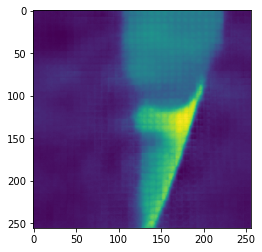

12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 213.5632 - mse: 0.0030 - val_loss: 223.3286 - val_mse: 0.0031
Epoch 66/300
12/12 [==============================] - 10s 903ms/step - batch: 5.5000 - size: 121.9167 - loss: 215.1821 - mse: 0.0030 - val_loss: 215.7280 - val_mse: 0.0030
Epoch 67/300
12/12 [==============================] - 10s 908ms/step - batch: 5.5000 - size: 121.9167 - loss: 212.3944 - mse: 0.0030 - val_loss: 212.2190 - val_mse: 0.0030
Epoch 68/300
12/12 [==============================] - 10s 907ms/step - batch: 5.5000 - size: 121.9167 - loss: 206.6488 - mse: 0.0029 - val_loss: 199.8005 - val_mse: 0.0028
Epoch 69/300
12/12 [==============================] - 10s 909ms/step - batch: 5.5000 - size: 121.9167 - loss: 201.0528 - mse: 0.0028 - val_loss: 201.8841 - val_mse: 0.0028
Epoch 70/300
12/12 [==============================] - 10s 929ms/step - batch: 5.5000 - size: 121.9167 - loss: 202.5453 - mse: 0.0028 - val_loss: 196.3485

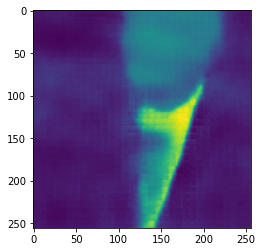

12/12 [==============================] - 10s 940ms/step - batch: 5.5000 - size: 121.9167 - loss: 200.7134 - mse: 0.0028 - val_loss: 196.4506 - val_mse: 0.0028
Epoch 74/300
12/12 [==============================] - 10s 906ms/step - batch: 5.5000 - size: 121.9167 - loss: 199.3216 - mse: 0.0028 - val_loss: 199.9157 - val_mse: 0.0028
Epoch 75/300
12/12 [==============================] - 10s 910ms/step - batch: 5.5000 - size: 121.9167 - loss: 201.7122 - mse: 0.0028 - val_loss: 192.9849 - val_mse: 0.0027
Epoch 76/300
12/12 [==============================] - 10s 922ms/step - batch: 5.5000 - size: 121.9167 - loss: 192.4619 - mse: 0.0027 - val_loss: 199.4494 - val_mse: 0.0028
Epoch 77/300
12/12 [==============================] - 10s 921ms/step - batch: 5.5000 - size: 121.9167 - loss: 198.1898 - mse: 0.0028 - val_loss: 193.5638 - val_mse: 0.0027
Epoch 78/300
12/12 [==============================] - 10s 910ms/step - batch: 5.5000 - size: 121.9167 - loss: 203.1910 - mse: 0.0029 - val_loss: 197.6244

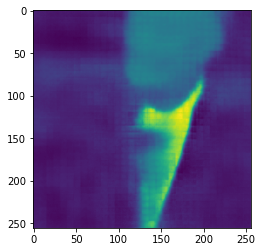

12/12 [==============================] - 11s 928ms/step - batch: 5.5000 - size: 121.9167 - loss: 191.6421 - mse: 0.0027 - val_loss: 186.8115 - val_mse: 0.0026
Epoch 82/300
12/12 [==============================] - 10s 890ms/step - batch: 5.5000 - size: 121.9167 - loss: 187.9513 - mse: 0.0026 - val_loss: 184.5916 - val_mse: 0.0026
Epoch 83/300
12/12 [==============================] - 10s 911ms/step - batch: 5.5000 - size: 121.9167 - loss: 193.4251 - mse: 0.0027 - val_loss: 186.7977 - val_mse: 0.0026
Epoch 84/300
12/12 [==============================] - 10s 917ms/step - batch: 5.5000 - size: 121.9167 - loss: 190.7090 - mse: 0.0027 - val_loss: 191.6560 - val_mse: 0.0027
Epoch 85/300
12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 194.5153 - mse: 0.0027 - val_loss: 182.7654 - val_mse: 0.0025
Epoch 86/300
12/12 [==============================] - 10s 925ms/step - batch: 5.5000 - size: 121.9167 - loss: 184.5233 - mse: 0.0026 - val_loss: 181.1093

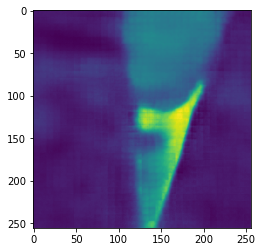

12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 182.0556 - mse: 0.0025 - val_loss: 184.1570 - val_mse: 0.0026
Epoch 90/300
12/12 [==============================] - 10s 890ms/step - batch: 5.5000 - size: 121.9167 - loss: 182.7606 - mse: 0.0025 - val_loss: 182.1929 - val_mse: 0.0025
Epoch 91/300
12/12 [==============================] - 10s 917ms/step - batch: 5.5000 - size: 121.9167 - loss: 188.6635 - mse: 0.0026 - val_loss: 183.9470 - val_mse: 0.0026
Epoch 92/300
12/12 [==============================] - 10s 907ms/step - batch: 5.5000 - size: 121.9167 - loss: 186.2186 - mse: 0.0026 - val_loss: 175.3118 - val_mse: 0.0024
Epoch 93/300
12/12 [==============================] - 10s 912ms/step - batch: 5.5000 - size: 121.9167 - loss: 182.9063 - mse: 0.0025 - val_loss: 186.5357 - val_mse: 0.0026
Epoch 94/300
12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 182.1205 - mse: 0.0025 - val_loss: 173.9723

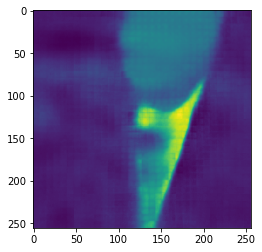

12/12 [==============================] - 11s 928ms/step - batch: 5.5000 - size: 121.9167 - loss: 178.1658 - mse: 0.0025 - val_loss: 173.9859 - val_mse: 0.0024
Epoch 98/300
12/12 [==============================] - 10s 893ms/step - batch: 5.5000 - size: 121.9167 - loss: 175.4887 - mse: 0.0024 - val_loss: 170.0315 - val_mse: 0.0024
Epoch 99/300
12/12 [==============================] - 10s 908ms/step - batch: 5.5000 - size: 121.9167 - loss: 175.4580 - mse: 0.0024 - val_loss: 174.0731 - val_mse: 0.0024
Epoch 100/300
12/12 [==============================] - 10s 909ms/step - batch: 5.5000 - size: 121.9167 - loss: 176.3935 - mse: 0.0024 - val_loss: 172.7941 - val_mse: 0.0024
Epoch 101/300
12/12 [==============================] - 10s 917ms/step - batch: 5.5000 - size: 121.9167 - loss: 178.3294 - mse: 0.0025 - val_loss: 179.9634 - val_mse: 0.0025
Epoch 102/300
12/12 [==============================] - 10s 903ms/step - batch: 5.5000 - size: 121.9167 - loss: 177.5195 - mse: 0.0025 - val_loss: 163.0

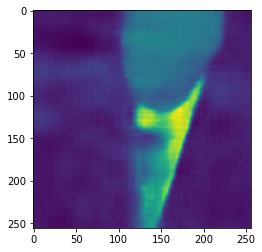

12/12 [==============================] - 11s 933ms/step - batch: 5.5000 - size: 121.9167 - loss: 173.4946 - mse: 0.0024 - val_loss: 170.1567 - val_mse: 0.0023
Epoch 106/300
12/12 [==============================] - 10s 888ms/step - batch: 5.5000 - size: 121.9167 - loss: 172.6360 - mse: 0.0024 - val_loss: 167.1361 - val_mse: 0.0023
Epoch 107/300
12/12 [==============================] - 10s 919ms/step - batch: 5.5000 - size: 121.9167 - loss: 171.5029 - mse: 0.0024 - val_loss: 169.3277 - val_mse: 0.0023
Epoch 108/300
12/12 [==============================] - 10s 934ms/step - batch: 5.5000 - size: 121.9167 - loss: 172.2436 - mse: 0.0024 - val_loss: 171.4081 - val_mse: 0.0024
Epoch 109/300
12/12 [==============================] - 10s 935ms/step - batch: 5.5000 - size: 121.9167 - loss: 166.2702 - mse: 0.0023 - val_loss: 167.8865 - val_mse: 0.0023
Epoch 110/300
12/12 [==============================] - 10s 910ms/step - batch: 5.5000 - size: 121.9167 - loss: 174.3251 - mse: 0.0024 - val_loss: 167

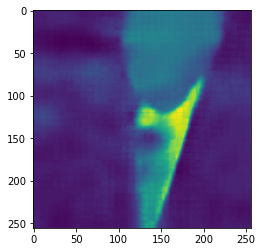

12/12 [==============================] - 10s 925ms/step - batch: 5.5000 - size: 121.9167 - loss: 168.9875 - mse: 0.0023 - val_loss: 163.1988 - val_mse: 0.0022
Epoch 114/300
12/12 [==============================] - 10s 904ms/step - batch: 5.5000 - size: 121.9167 - loss: 170.3313 - mse: 0.0024 - val_loss: 164.6863 - val_mse: 0.0023
Epoch 115/300
12/12 [==============================] - 10s 929ms/step - batch: 5.5000 - size: 121.9167 - loss: 170.2415 - mse: 0.0023 - val_loss: 162.7520 - val_mse: 0.0022
Epoch 116/300
12/12 [==============================] - 10s 924ms/step - batch: 5.5000 - size: 121.9167 - loss: 168.9456 - mse: 0.0023 - val_loss: 167.4403 - val_mse: 0.0023
Epoch 117/300
12/12 [==============================] - 11s 928ms/step - batch: 5.5000 - size: 121.9167 - loss: 167.3781 - mse: 0.0023 - val_loss: 171.1760 - val_mse: 0.0024
Epoch 118/300
12/12 [==============================] - 11s 943ms/step - batch: 5.5000 - size: 121.9167 - loss: 170.3297 - mse: 0.0024 - val_loss: 165

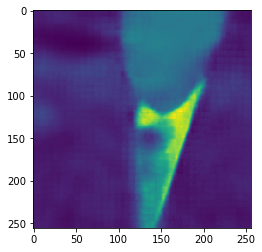

12/12 [==============================] - 11s 932ms/step - batch: 5.5000 - size: 121.9167 - loss: 169.0144 - mse: 0.0023 - val_loss: 166.6631 - val_mse: 0.0023
Epoch 122/300
12/12 [==============================] - 10s 919ms/step - batch: 5.5000 - size: 121.9167 - loss: 165.3442 - mse: 0.0023 - val_loss: 161.1264 - val_mse: 0.0022
Epoch 123/300
12/12 [==============================] - 10s 906ms/step - batch: 5.5000 - size: 121.9167 - loss: 164.4111 - mse: 0.0023 - val_loss: 163.4822 - val_mse: 0.0022
Epoch 124/300
12/12 [==============================] - 10s 918ms/step - batch: 5.5000 - size: 121.9167 - loss: 162.9208 - mse: 0.0022 - val_loss: 155.9618 - val_mse: 0.0021
Epoch 125/300
12/12 [==============================] - 11s 948ms/step - batch: 5.5000 - size: 121.9167 - loss: 164.1417 - mse: 0.0023 - val_loss: 163.6242 - val_mse: 0.0023
Epoch 126/300
12/12 [==============================] - 10s 910ms/step - batch: 5.5000 - size: 121.9167 - loss: 164.7575 - mse: 0.0023 - val_loss: 178

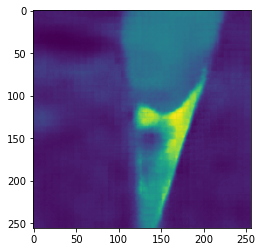

12/12 [==============================] - 11s 948ms/step - batch: 5.5000 - size: 121.9167 - loss: 163.7200 - mse: 0.0023 - val_loss: 161.0742 - val_mse: 0.0022
Epoch 130/300
12/12 [==============================] - 10s 902ms/step - batch: 5.5000 - size: 121.9167 - loss: 163.8217 - mse: 0.0023 - val_loss: 161.2841 - val_mse: 0.0022
Epoch 131/300
12/12 [==============================] - 10s 939ms/step - batch: 5.5000 - size: 121.9167 - loss: 162.0677 - mse: 0.0022 - val_loss: 156.6335 - val_mse: 0.0021
Epoch 132/300
12/12 [==============================] - 10s 922ms/step - batch: 5.5000 - size: 121.9167 - loss: 162.2149 - mse: 0.0022 - val_loss: 154.5574 - val_mse: 0.0021
Epoch 133/300
12/12 [==============================] - 10s 920ms/step - batch: 5.5000 - size: 121.9167 - loss: 168.4925 - mse: 0.0023 - val_loss: 175.2772 - val_mse: 0.0024
Epoch 134/300
 3/12 [======>.......................] - ETA: 1s - batch: 1.0000 - size: 103.6667 - loss: 167.3145 - mse: 0.0023  

In [ ]:
model_uch.fit(
    x=train_generator_uch,
    epochs=300,
    shuffle=True,
    validation_data = validation_generator_uch,
    callbacks=[CustomCallback()]
)
model_uch.save("uch_ae.h5")

In [ ]:
import cv2
import glob
import re
import os
img_array = []

for filename in sorted(glob.glob('created_img/*.png'),key=lambda x: int(re.findall("[0-9]+", x)[0])):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


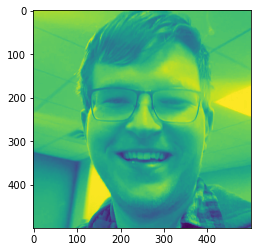

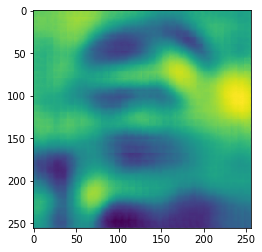

True

In [43]:
face = cv2.imread("autoencoder/pics/denver1/denver/denver_face1748.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
plt.imshow(face)
plt.show()
face = cv2.resize(face,(256,256))
face = np.reshape(face, (1,256,256,1))
face = face/255
uch_pred = encoder.predict(face)
output = decoder.predict(uch_pred)
output = np.reshape(output,(256,256))
output = output*255
plt.imshow(output)
plt.show()
cv2.imwrite("autoencoder/bryan2bryan.png", output)

In [17]:
face = cv2.imread("autoencoder/pics/uchtdorf1/uchtdorf/uchtdorf_face1860.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face = cv2.resize(face,(256,256))
face = np.reshape(face, (1,256,256,1))
face = face/255
uch_pred = encoder_uch.predict(face)
output = decoder.predict(uch_pred)
output = np.reshape(output,(256,256))
output = output*255
plt.imshow(output)
plt.show()
cv2.imwrite("autoencoder/uch2bryan.png", output)

/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


True

In [18]:
face = cv2.imread("autoencoder/pics/uchtdorf1/uchtdorf/uchtdorf_face1860.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face = plt.imshow(face)
plt.show()
face = cv2.resize(face,(256,256))
# face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = np.reshape(face, (1,256,256,1))
face = face/255
uch_pred = encoder.predict(face)
output = decoder_uch.predict(uch_pred)
output = np.reshape(output,(256,256))
output = output*255
output = plt.imshow(output)
plt.show()
print(output)
cv2.imwrite("autoencoder/bryan2uch.png", output)

/projects/fpga_packet/mambaforge/envs/5g/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[73.158646 71.86848  75.54901  ... 70.44346  67.81974  78.289825]
 [72.194916 59.513496 65.72693  ... 68.88412  60.87049  64.83062 ]
 [72.773575 72.18363  72.702774 ... 69.25699  67.9479   70.96266 ]
 ...
 [81.69774  76.990875 82.0752   ... 70.40954  71.64061  72.11833 ]
 [82.80631  79.38874  80.014084 ... 73.518486 72.036514 74.37137 ]
 [90.321365 79.19084  82.99035  ... 76.29884  73.7122   82.407234]]


True

In [19]:
face = cv2.imread("autoencoder/pics/uchtdorf1/uchtdorf/uchtdorf_face1860.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face = cv2.resize(face,(256,256))
# face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = np.reshape(face, (1,256,256,1))
face = face/255
uch_pred = encoder_uch.predict(face)
output = decoder_uch.predict(uch_pred)
output = np.reshape(output,(256,256))
output = output*255
print(output)
cv2.imwrite("autoencoder/uch2uch.png", output)

[[10.202295  14.393406  14.998775  ... 13.9431715 13.435194  27.458897 ]
 [ 9.94217   13.233146  11.239101  ... 11.753511  14.3036585 13.810681 ]
 [11.970908  11.211279  12.538871  ... 14.456444  13.488461  19.487148 ]
 ...
 [56.583935  52.86548   60.51638   ... 62.66951   61.07084   64.36089  ]
 [58.870716  56.28285   55.960007  ... 62.749676  62.079266  65.62032  ]
 [74.44507   61.669598  63.37912   ... 66.496956  69.48049   73.47808  ]]


True